![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.3.Spark_OCR_Utility_Module.ipynb)

# Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [2]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY'])

In [ ]:
# Installing Spark OCR
! pip install --upgrade -q spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [2]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys),
os.environ.update(license_keys)

In [3]:
import sys
import os
import base64
import pkg_resources
import pandas as pd
import xml.etree.ElementTree as ET
from lxml import etree
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import re

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import sparkocr
from sparkocr import start
from sparkocr.enums import *
from sparkocr.utils import display_images
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image
from sparkocr.metrics import score

spark = sparkocr.start(secret=SPARK_OCR_SECRET,
                       nlp_version=PUBLIC_VERSION,
                       nlp_secret=SECRET,
                       nlp_internal=JSL_VERSION
                       )
spark

Spark version: 3.2.1
Spark NLP version: 4.4.1
Spark NLP for Healthcare version: 4.4.3
Spark OCR version: 4.4.2



In [4]:
spark.conf.set("spark.sql.legacy.allowUntypedScalaUDF", True)
print(spark.conf.get("spark.sql.legacy.allowUntypedScalaUDF"))

true


In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_OCR_00.pdf -P content/

# NER Pipeline

In [6]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# Clinical word embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("clinical_ner")

clinical_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "clinical_ner"]) \
    .setOutputCol("clinical_ner_chunk") \
    .setBlackList(["TREATMENT"])

posology_ner = MedicalNerModel.pretrained("ner_posology_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("posology_ner")

posology_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "posology_ner"]) \
    .setOutputCol("posology_ner_chunk")

deid_ner = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("deid_ner")

deid_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "deid_ner"]) \
    .setOutputCol("deid_ner_chunk")

chunk_merger = ChunkMergeApproach()\
    .setInputCols(["clinical_ner_chunk", "posology_ner_chunk", "deid_ner_chunk"])\
    .setOutputCol("merged_chunk")

nlp_pipeline = Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        clinical_ner_converter,
        posology_ner,
        posology_ner_converter,
        deid_ner,
        deid_ner_converter,
        chunk_merger
    ])
empty_data = spark.createDataFrame([[""]]).toDF("text")
nlp_model = nlp_pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology_large download started this may take some time.
[OK!]
ner_deid_subentity_augmented download started this may take some time.
[OK!]


# Module

In [7]:
from sparknlp_jsl.utils.ocr_nlp_processor import ocr_entity_processor

### Description of the labels

+ file_path = path to pdf file
+ ner_pipeline = fitted NER pipeline,
+ chunk_col = output col name of the NER pipeline,
+ style = type of the process,
+ save_path = path to save file,
+ label= if True, labels show up
+ label_color = color of the label
+ display_result = show output
+ black_list = labels that will be banded over (like PHI). Each label will be banded over with the assigned color.


### Black Box

In [8]:
# Black Band without display

path='content/*.pdf'
box = "black_band"

# black_band
ocr_entity_processor(spark=spark,
                    file_path = path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    style = box,
                    save_dir = "black_band",
                    label= True,
                    label_color = "red",
                    resolution=100,
                    display_result = False)

OCR pipeline is running...
Drawing black box...
Saving started...
File saved to black_band/MT_OCR_00_black_band.pdf successfully.


OCR pipeline is running...
Drawing black box...
Saving started...
File saved to black_band/MT_OCR_00_black_band.pdf successfully.


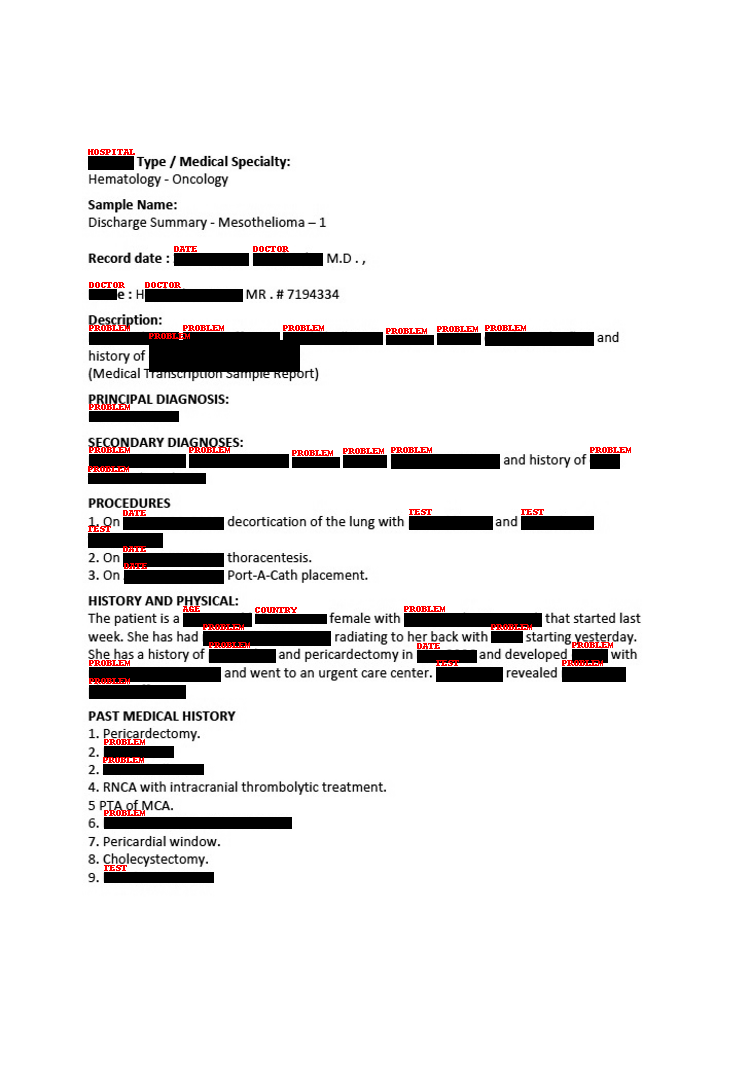

In [9]:
# black_band with labels

path='content/*.pdf'
box = "black_band"

ocr_entity_processor(spark=spark,
                     file_path=path,
                     ner_pipeline = nlp_model,
                     chunk_col = "merged_chunk",
                     style = box,
                     save_dir = "black_band",
                     label= True, label_color = "red",
                     resolution=100,
                     display_result = True)

OCR pipeline is running...
Drawing black box...
Saving started...
File saved to black_band/MT_OCR_00_black_band.pdf successfully.


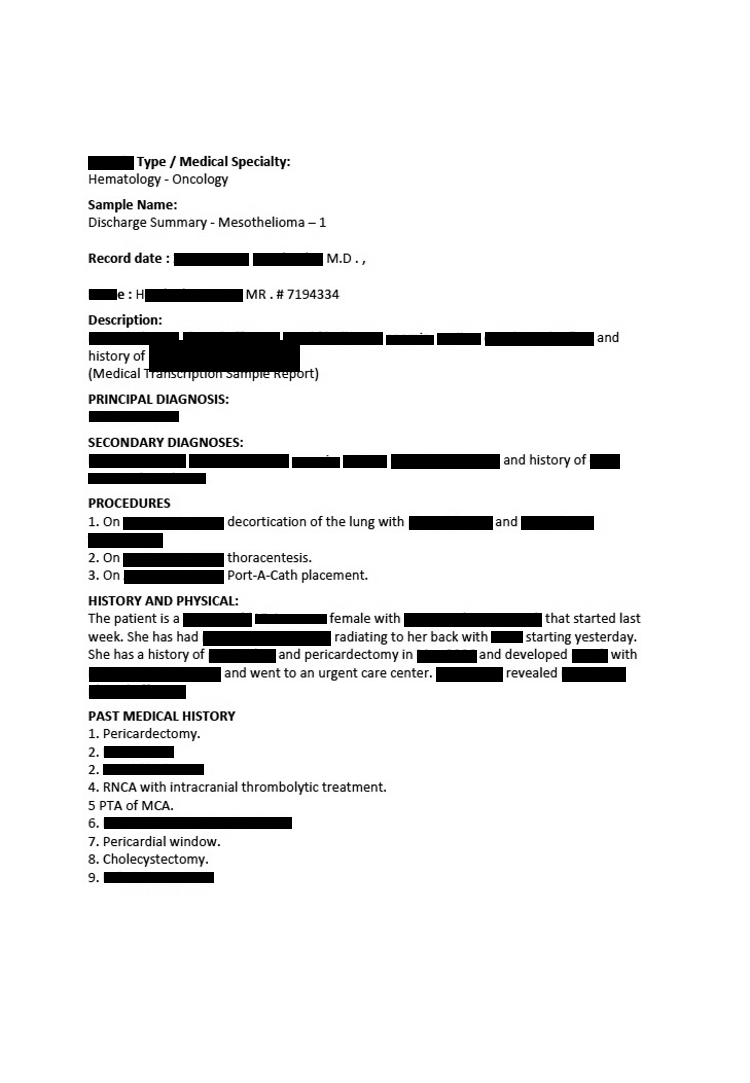

In [10]:
# black_band without labels

path='content/*.pdf'
box = "black_band"

ocr_entity_processor(spark=spark,
                    file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    style = box,
                    save_dir = "black_band",
                    label= False,
                    label_color = "red",
                    resolution=100,
                    display_result = True)

### Colored Box

OCR pipeline is running...
Drawing colored box...
Saving started...
File saved to colored_box/MT_OCR_00_bounding_box.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


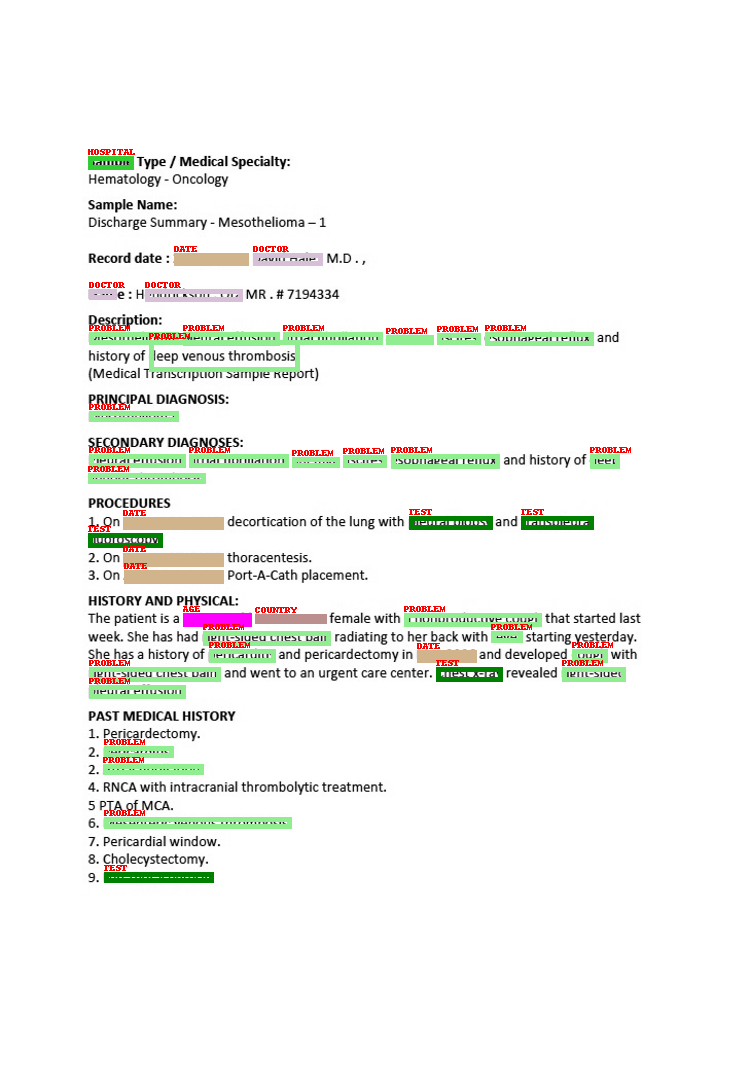

In [11]:
# BB with labels and black list

path='content/*.pdf'
box = "bounding_box"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

OCR pipeline is running...
Drawing colored box...
Saving started...
File saved to colored_box/MT_OCR_00_bounding_box.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


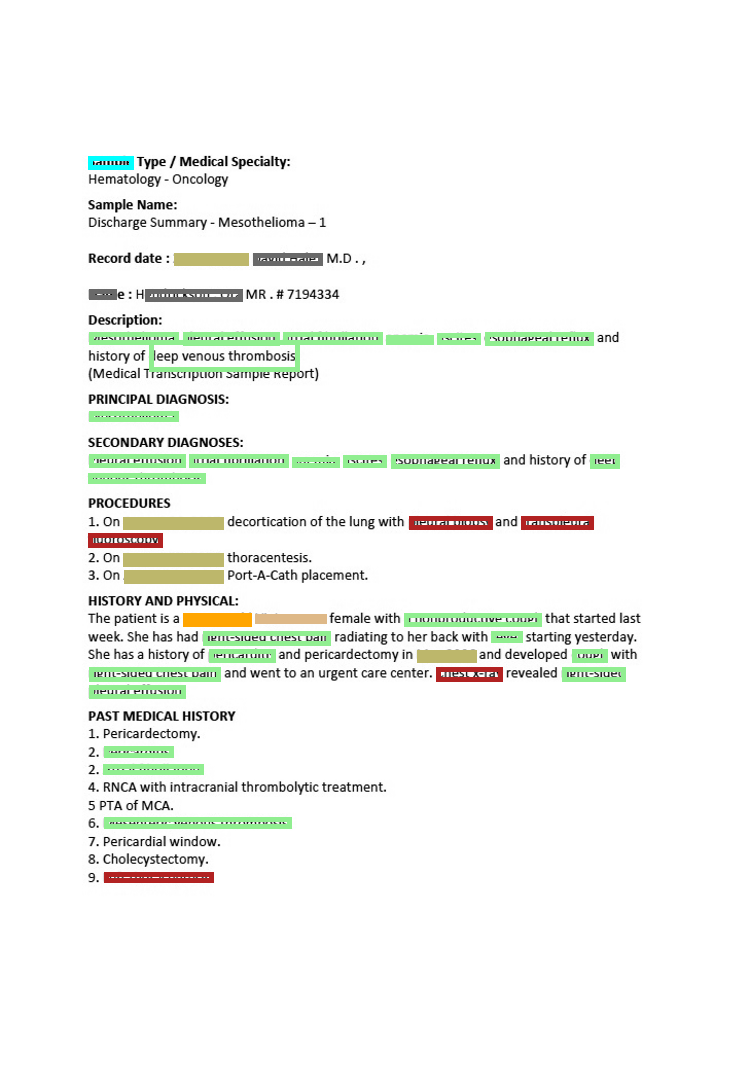

In [12]:
# BB with black list and without labels

path='content/*.pdf'
box = "bounding_box"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= False,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

In [13]:
# BB without display

path='content/*.pdf'
box = "bounding_box"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=False)

OCR pipeline is running...
Drawing colored box...
Saving started...
File saved to colored_box/MT_OCR_00_bounding_box.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


OCR pipeline is running...
Drawing colored box...
Saving started...
File saved to colored_box/MT_OCR_00_bounding_box.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


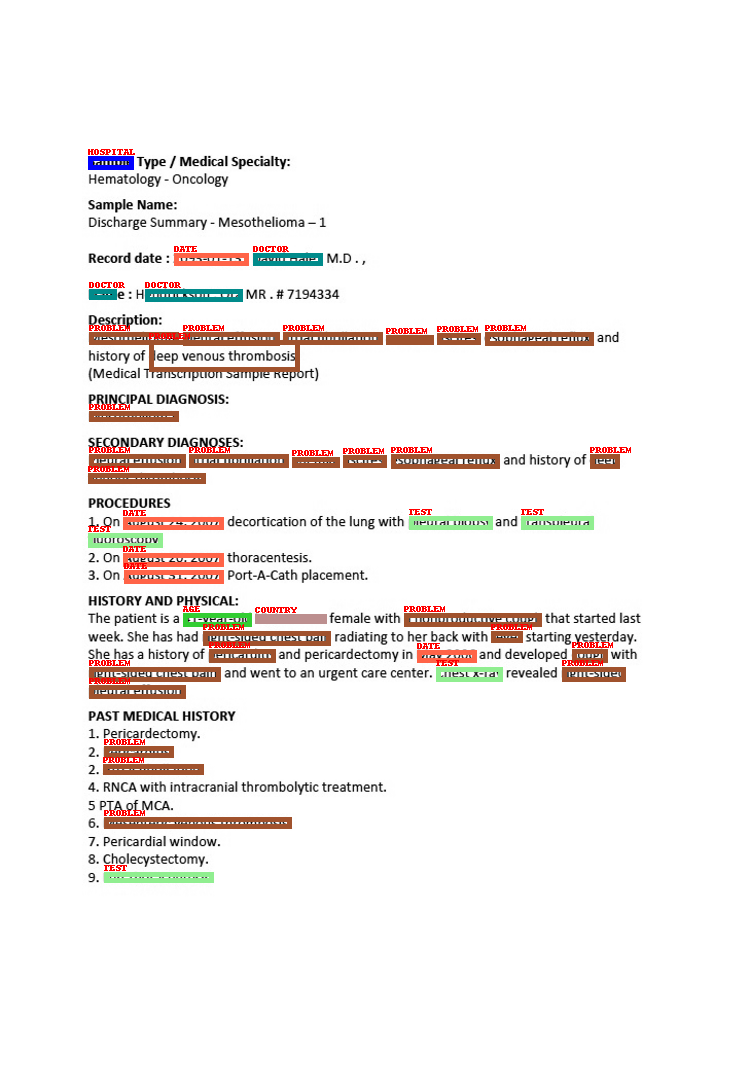

In [14]:
# BB without black list

path='content/*.pdf'
box = "bounding_box"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

OCR pipeline is running...
Drawing colored box...
Saving started...
File saved to colored_box/MT_OCR_00_bounding_box.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


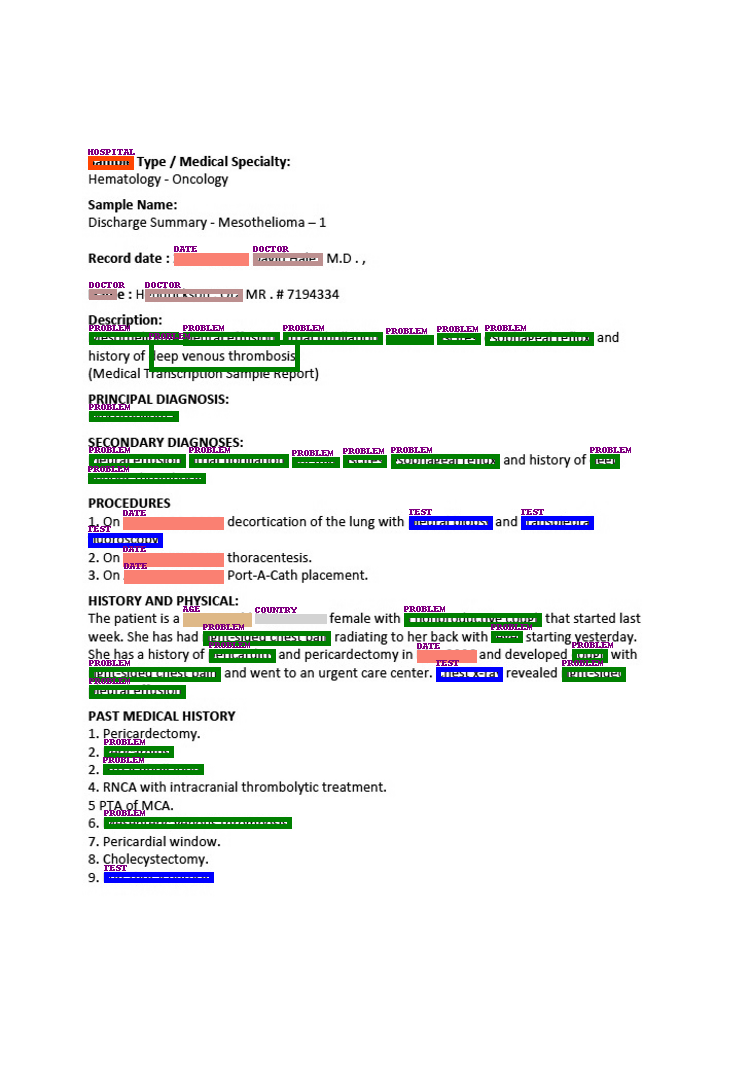

In [15]:
# BB change label color

path='content/*.pdf'
box = "bounding_box"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DATE", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "purple",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

### Highlighted Box

OCR pipeline is running...
Highlighting...
Saving started...
File saved to colored_box/MT_OCR_00_highlight.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


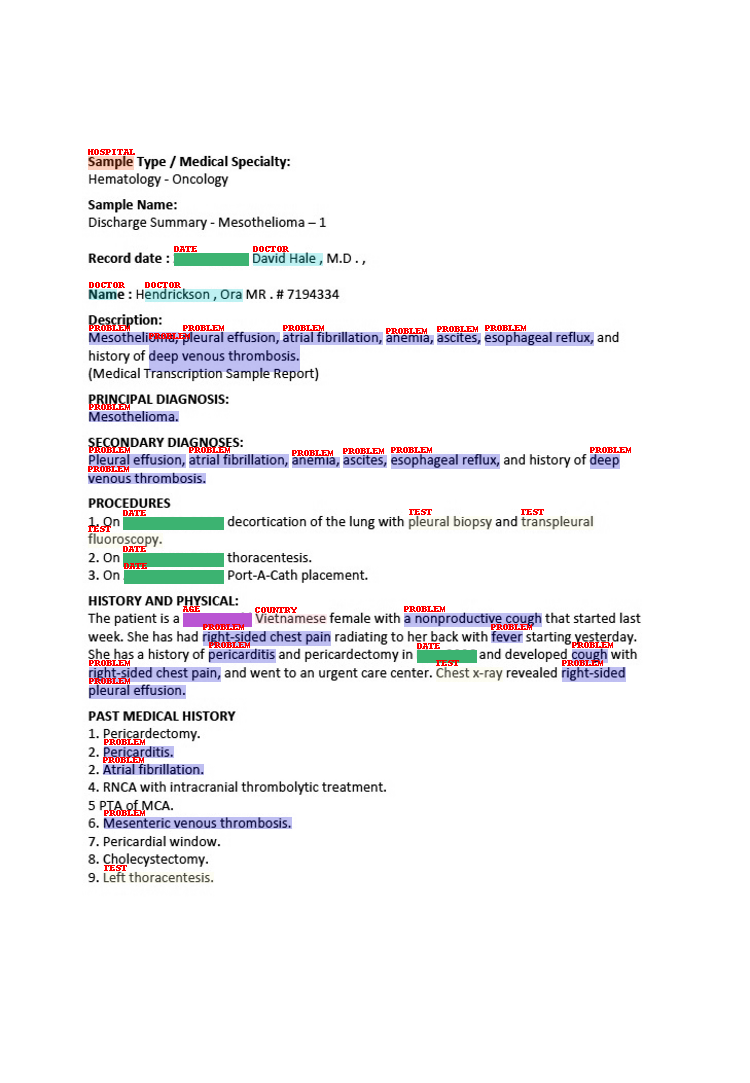

In [16]:
# Highlight with labels and black_list

path='content/*.pdf'
box = "highlight"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DATE", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

OCR pipeline is running...
Highlighting...
Saving started...
File saved to colored_box/MT_OCR_00_highlight.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


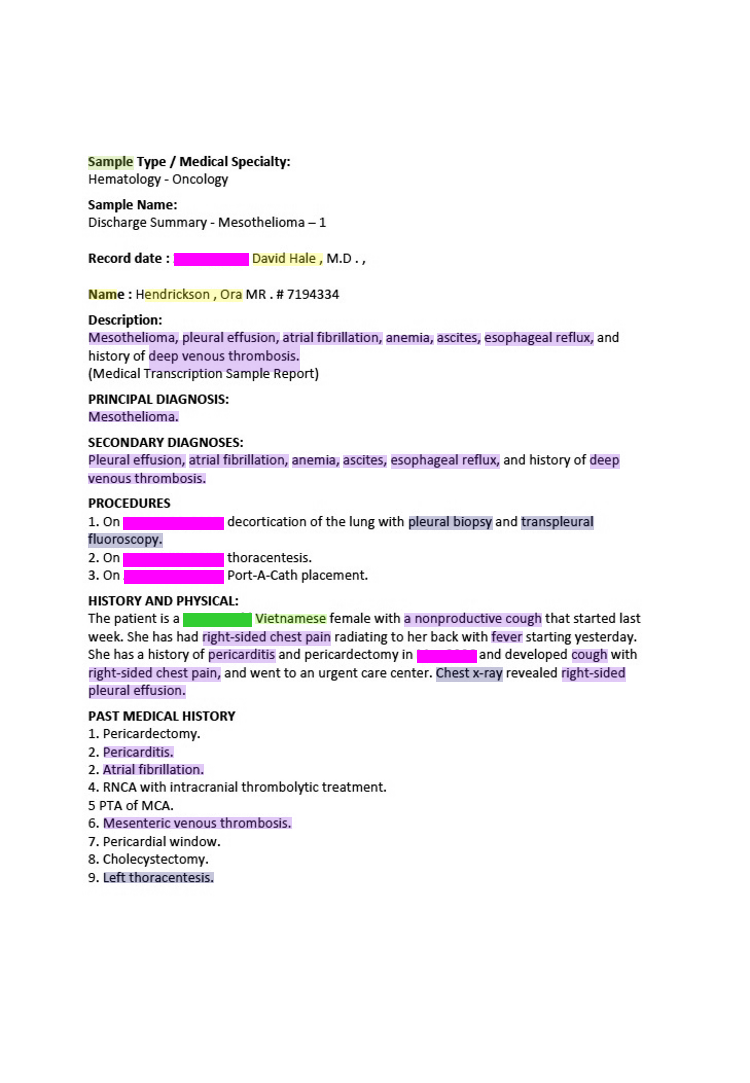

In [17]:
# Highlight without labels and with black_list

path='content/*.pdf'
box = "highlight"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= False,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

OCR pipeline is running...
Highlighting...
Saving started...
File saved to colored_box/MT_OCR_00_highlight.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


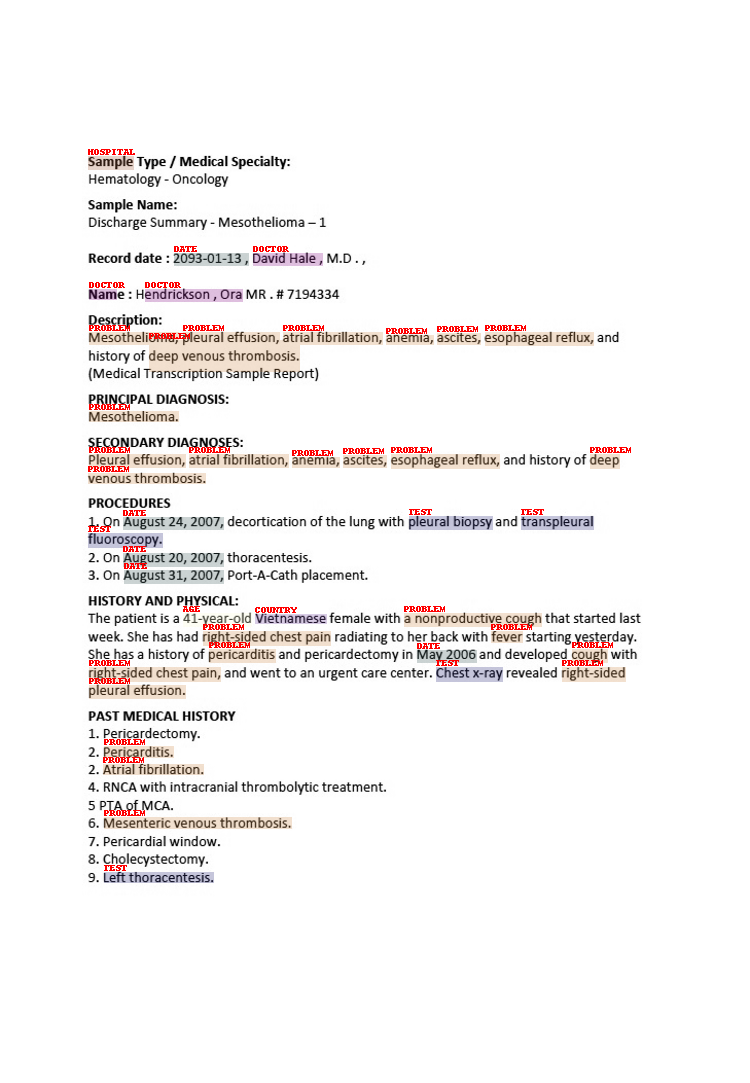

In [18]:
# Highlight with labels and without black_list

path='content/*.pdf'
box = "highlight"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)

In [19]:
# Highlight without display

path='content/*.pdf'
box = "highlight"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "red",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=False)

OCR pipeline is running...
Highlighting...
Saving started...
File saved to colored_box/MT_OCR_00_highlight.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


OCR pipeline is running...
Highlighting...
Saving started...
File saved to colored_box/MT_OCR_00_highlight.pdf successfully.
Color chart of the entity labels is saved to label_colors.png.


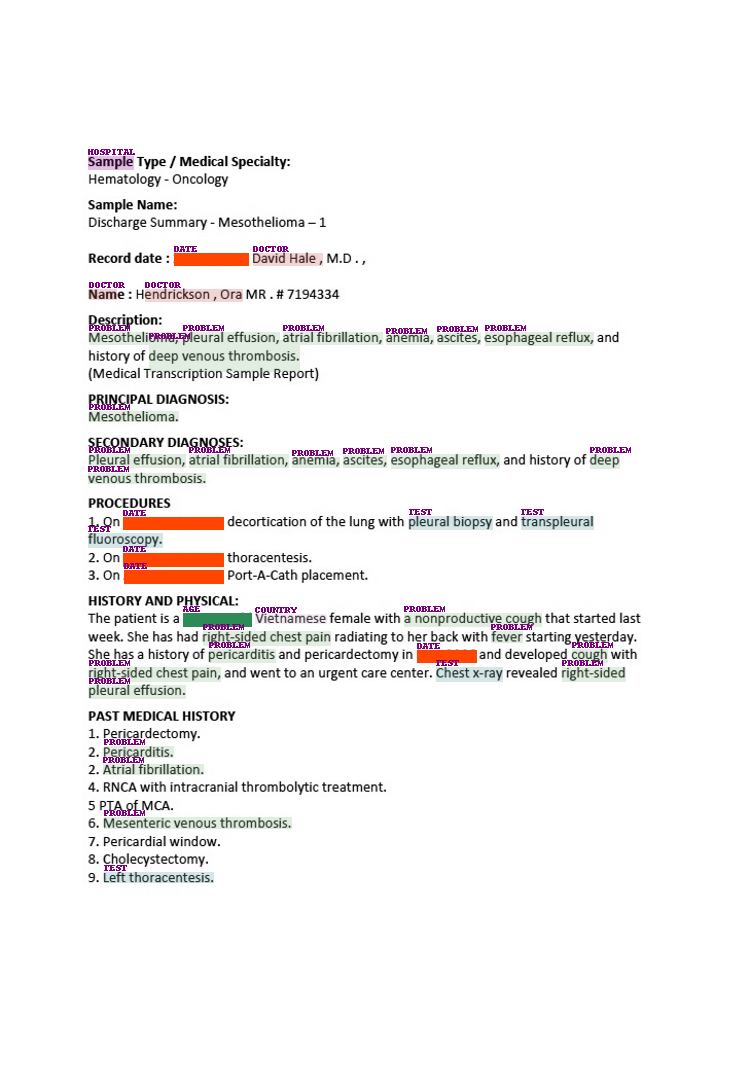

In [20]:
# Highlight change label color

path='content/*.pdf'
box = "highlight"

ocr_entity_processor(spark=spark,
                     file_path=path,
                    ner_pipeline = nlp_model,
                    chunk_col = "merged_chunk",
                    black_list = ["AGE", "DAte", "PATIENT"],
                    style = box,
                    save_dir = "colored_box",
                    label= True,
                    label_color = "purple",
                    color_chart_path = "label_colors.png",
                    resolution=100,
                    display_result=True)